In [ ]:
# default_exp widgets

In [ ]:
# export
from snkrfinder.imports import *
from snkrfinder.core import *
from snkrfinder.data import *
from snkrfinder.model import *
from snkrfinder.cvae import *

#from ipywidgets import widgets
#from ipywidgets import HBox,VBox,widgets,Button,Checkbox,Dropdown,Layout,Box,Output,Label,FileUpload
from fastai.vision.widgets import *


In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
%load_ext autoreload
%autoreload 2

# first snkrfinder.model b



## OVERVIEW: model module- MobileNet_v2 feature extractor

This is a project initiated while an Insight Data Science fellow.  It grew out of my interest in making data driven tools in the fashion/retail space I had most recently been working.   The original over-scoped idea was to make a shoe desighn tool which could quickly develop some initial sneakers based on choosing some examples, and some text descriptors.  Designs are constrained by the "latent space" defined (discovered?) by a database of shoe images.  However, given the 3 week sprint allowed for development, I pared the tool down to a simple "aesthetic" recommender for sneakers, using the same idea of utilizing an embedding space defined by the database fo shoe images.

Feature extractor: 
    1. embed database into feature space.
    2. evaluate/validate by simple logistic regression on classification.


## Part 2: create tools out of widgets... litterally SneakerFinder 2.0

In [ ]:
#hide
print(fastai.__version__)

2.2.5


In [ ]:
print(Path().cwd())
os.chdir(L_ROOT)
print(Path().cwd())

/home/ergonyc/Projects/Project2.0/snkr-finder/nbs
/home/ergonyc/Projects/Project2.0/snkr-finder


In [ ]:
# this should go into a utils or cfg module
HOME = get_home()

In [ ]:


images_path = D_ROOT/DBS['zappos']


##  mobilenet v2

We will use Google's mobileNetV2 trained on ImageNet loaded from torchvision to embed our sneakers into a feature space.  

### decapitate mobilnet_v2 (neuter)

Because we simply want to collect the _features_ output from the model rather than do classification (or some other decision) I replaced the clasiffier _head_ with a simple identity mapper.   The simple Identity nn.Module class makes this simple.

Finally, since we are calculating the features, or _embedding_ over 30k images with the net lets load the computations onto our GPU.  We need to remember to do this in evaluation mode so Batch Norm / Dropout layers are disabled.  [I forgot to do this initally and lost hours trying to figure out why i wasn't getting consistent results]. Setting `param.requires_grad = False` saves us memory since we aren't going to fit any weights for now, and protects us in case we forget to do a `with torch.no_grad()` before inference.

Later when we use the full FastAI API this should all be handled elegantly behind the scenes

In [ ]:
#hide
filename = ZAPPOS_FEATS_ALL_SORT # "zappos-50k-mobilenetv2-features_sort_3"
df = pd.read_pickle(f"data/{filename}.pkl")


## SANITY CHECK: 

Just want to chack that we can we extract single features that match those we just calculated.

In [ ]:
# sicne we made sure our indices match up with our "classes" things should be easy
query_image = "Shoes/Sneakers and Athletic Shoes/Nike/7716996.288224.jpg"

df.loc[df.path==query_image,['path','classes_md']]



,path,classes_md
27079,Shoes/Sneakers and Athletic Shoes/Nike/7716996.288224.jpg,27079


The DataBlock performed a number of processing steps to prepare the images for embedding into the MobileNet_v2 space (1280 vector).  We have already confirmed that the functional wrapers work, but lets go ahead and spot-check the equivalence of my functions and the fastaai API.

That seemed to work well.  I'll just wrap it in a simple function for now, though a FastAI Pipeline might work the best in the long run.

My _by hand_ pipeline:

```python
# get net, prep image
mnet1 = get_mnetV2_feature_net(to_cuda=False)
t_image1 = load_and_prep_sneaker(image_path,size=IMG_SIZE,to_cuda=False)
    
```
versus the fastai based objects I defined:

```python
# FASTAI: get net, prep image, get feats 

mnet2 = create_cnn_featurenet(torchvision.models.mobilenet_v2,to_cuda=True)
t_image2 = load_and_prep_tf_pipe() # Pipeline
        
```

Then we can go ahead and extract features and process with the functions to query the images agains the database and visualize:

```python
feats = get_mnet_feature(mnetv2,t_image,to_cuda=False)
reducer = get_umap_reducer(latents)
neigh_images = query_neighs(q_feat, myneighs, data, root_path, show = True)
plot_sneak_neighs(neigh_images)
```    

In [ ]:

mnet1 = get_mnetV2_feature_net()
query_t1 = load_and_prep_sneaker(images_path/QUERY_IM)
test_feats1 = get_mnet_feature(mnet1,query_t1)


mnet2 = create_cnn_featurenet(torchvision.models.mobilenet_v2)
query_t2 = load_and_prep_tf_pipe(images_path/QUERY_IM)
test_feats2 = get_mnet_feature(mnet2,query_t2)


test_feats1.mean(),test_feats2.mean(),(test_feats1-test_feats2).max(),
#PILImage.create((query_t1-query_t2).squeeze())


(TensorImage(1.2784), TensorBase(1.2858), TensorImage(5.1147))

Now I have the "embeddings" of the database in the mobileNet_v2 output space.  I can do a logistic regression on these vectors (should be identical to mapping these 1000 vectors to 4 categories (Part 3)) but I can also use an approximate KNN in this space to run the SneakerFinder tool.


## k-Nearest Neighbors: a proxy for "similar"

I'll start with a simple "gut" test, and point out that thre realy isn't a ground truth to refer to.  Remember that the goal of all this is to find some shoes that someone will like, and we are using "similar" as the aproximation of human preference.

Lets use our previously calculated sneaker-features and inspect that the k- nearest neighbors in our embedding space are _feel_ or _look_ "similar".

Personally, I like Jordans so I chose this as my `query_image`: <img alt="Sample Jordan" width="450" src="/home/ergonyc/.fastai/data/ut-zap50k-images/Shoes/Sneakers and Athletic Shoes/Nike/7716996.288224.jpg">

In [ ]:
num_neighs = 5
filename = f"data/knnXsize_nn{num_neighs}.pkl"
knns = load_pickle(filename)

filename = f"data/umapXsize.pkl"
reducers = load_pickle(filename)
        

In [ ]:
test_feats = test_feats2
neighs = knns[0]
distance, nn_index = neighs.kneighbors(test_feats, return_distance=True)    


dist = distance.tolist()[0] 

In [ ]:

similar_images =  get_similar_images(df,mnet2,knns)
plot_sneak_neighs(similar_images)

Looks like everything is now working

In [ ]:
ABBR

{'small': 'sm', 'medium': 'md', 'large': 'lg'}

In [ ]:
#def get_umap_embedding(latents):
fn = df.path.values

features = f"features_{SIZE_ABBR['small']}"
print(features)
data = df[['Category',features]].copy()
db_feats = np.vstack(data[features].values)

type(db_feats)

snk2vec = dict(zip(fn,db_feats))

snk2vec[list(snk2vec.keys())[0]]

embedding = get_umap_embedding(db_feats)
snk2umap = dict(zip(fn,embedding))



features_sm


## Widgets: make this into a "tool"


In [ ]:
num_neighs = 5


knns, reducers = get_neighs_and_reducers(df,num_neighs=num_neighs)

In [ ]:
wigetDB = {"knns":knns,
           "umaps":reducers}


with open('wigetDB.pkl', 'wb') as h:
    pickle.dump(wigetDB, h, protocol=pickle.HIGHEST_PROTOCOL)
    
    

{'knns': [NearestNeighbors(), NearestNeighbors(), NearestNeighbors()],
 'umaps': [UMAP(dens_frac=0.0, dens_lambda=0.0, random_state=666),
  UMAP(dens_frac=0.0, dens_lambda=0.0, random_state=666),
  UMAP(dens_frac=0.0, dens_lambda=0.0, random_state=666)]}

In [ ]:
neighs = knns[0]
distance, nn_index = neighs.kneighbors(test_feats, return_distance=True)    


dist = distance.tolist()[0] 

# make the paths easily accessible
paths = df[['path','classes_sm','classes_md','classes_lg']]
neighbors = paths.iloc[nn_index.tolist()[0]].copy()

df.columns

NameError: name 'test_feats' is not defined

In [ ]:
ts = [display(img.to_thumb(200,200))]+[display(i.to_thumb(100,100)) for i in images]

nnc = carousel(ts, width='1200px')

out_pl = HBox[display(img.to_thumb(200,200)), carousel]

In [ ]:
key = {sz:i for (i,sz) in enumerate(IMG_SIZES)}
    
[x for x in IMG_SIZES.values()].index(128)


#hide
filename = "zappos-50k-mobilenetv2-features_sort_3"
df = pd.read_pickle(f"data/{filename}.pkl")

mnetv2 = get_mnetV2_feature_net(to_cuda=False)


0

In [ ]:
# export
  
    

#define my widgets
btn_run = widgets.Button(description='Find k-nearest neighbors')
out_pl = widgets.Output()
car_pl = widgets.Output()
lbl_neighs = widgets.Label()
btn_upload = widgets.FileUpload()


# load our knn & umaps fit to the DB
with open('wigetDB.pkl', 'rb') as h:
    wigetDB = pickle.load(h)    
knns = wigetDB['knns']
umaps = wigetDB['umaps']
#default to sm 
neighs = knns[0]
umap = umaps[0]


def on_click_find_similar(change):
    """ """
    load_pipe = Pipeline([PILImage.create,
                     Resize(size=IMG_SIZE, method='pad', pad_mode='border')]
                        )
    prep_tf_pipe = Pipeline([ToTensor(),
                     IntToFloatTensor(),
                     Normalize.from_stats(*imagenet_stats,cuda=False)]
                   )
    
    # load the image
    im = btn_upload.data[-1]
    img = load_pipe(im)
    tensor_im = prep_tf_pipe(img)
    feats = get_mnet_feature(mnetv2, tensor_im )
    
    # find the neighbors
    distance, nn_index = neighs.kneighbors(feats.numpy(), return_distance=True)    
    dist = distance.tolist()[0] 
    # fix path to the database...
    neighbors = df.iloc[nn_index.tolist()[0]].copy()
    nbr = neighbors.index

    widget(im, max_width="292px")
    
    images = [ PILImage.create(images_path/f) for f in neighbors.path] 
    ts = [widget(im, max_width="292px") for im in images]
    target_im = img.to_thumb(200,200)
    
    nn_car = carousel(ts, width='1200px')
    
    out_pl.clear_output()
    with out_pl:
        display(HBox([widget(target_im, max_width="292px"), nn_car]))

    lbl_neighs.value = f'distances: {dist}'   


    
btn_run.on_click(on_click_find_similar)

output = widgets.Output()
plot_output = widgets.Output()

dd_im_size = widgets.Dropdown(options =  IMG_SIZES,
                                 description='Image Size:' )                       
dd_lat_dim = widgets.Dropdown(options = [32,64,128], 
                                     description='N Latents:')


def refresh_params(im_sz, lat_dim):
    output.clear_output()
    #key = {sz:i for (i,sz) in enumerate(IMG_SIZES)}
    print(f"im_size={im_sz}  lat_dim={lat_dim}")
    ii = [x for x in IMG_SIZES.values()].index(im_sz)
    umap = umaps[ii]
    neighs = knns[ii]
    # TODO:  plot the latent space
    #     with output
    #         display([])
    #     with plot_output:
    #         sns.kdeplot(common_filter['visits'], shade=True)
    #         plt.show()
    
def dd_im_size_eh(change):
    refresh_params(change.new, dd_lat_dim.value)                             
def dd_lat_dim_eh(change):
    refresh_params(dd_im_size.value, change.new)

dd_im_size.observe(dd_im_size_eh, names='value')
dd_lat_dim.observe(dd_lat_dim_eh, names='value')


#item_layout = widgets.Layout(margin='0 0 50px 0')
input_widgets = widgets.HBox([dd_im_size, dd_lat_dim])

nn_select = HBox([btn_run,input_widgets])

tab = widgets.Tab([output, plot_output],layout=item_layout)
tab.set_title(0, 'Dataset Exploration')
tab.set_title(1, 'KDE Plot')

btn_run.on_click(on_click_find_similar)


dashboard =  widgets.VBox([widgets.Label('Find your sneaker!'), 
      btn_upload, 
      nn_select,
      out_pl, 
      lbl_neighs,
      tab])

display(dashboard)

im_size=160  lat_dim=32
im_size=224  lat_dim=32
im_size=160  lat_dim=32


In [ ]:
VBox([widgets.HTML('aj1'),
      widget(im, max_width="292px")])

In [ ]:
ts = [VBox([widget(im, max_width='292px'), Button(description='click')])
      for o in range(3)]

carousel(ts, width='1200px')

Box(children=(VBox(children=(Output(layout=Layout(max_width='292px')), Button(description='click', style=Butto…

In [ ]:
QUERY_IM = "Shoes/Sneakers and Athletic Shoes/Nike/7716996.288224.jpg"
QUERY_IM2 = 'figs/491212_01.jpg.jpeg'

im = Image.open(QUERY_IM2).to_thumb(256,512)
VBox([widgets.HTML('aj1'),
      widget(im, max_width="292px")])

ts = [VBox([widget(im, max_width='292px'), Button(description='click')])
      for o in range(3)]

In [ ]:
widgets.IntSlider(
    min=0,
    max=10,
    step=1,
    description='Slider:',
    value=3
)

IntSlider(value=3, description='Slider:', max=10)

In [ ]:
slider = widgets.IntSlider(min=0,
                            max=10,
                            step=1,
                            description='Slider:',
                            value=3)
text = widgets.IntText()
display(slider, text)
widgets.jslink((slider, 'value'), (text, 'value'))

IntSlider(value=3, description='Slider:', max=10)

IntText(value=0)

Link(source=(IntSlider(value=3, description='Slider:', max=10), 'value'), target=(IntText(value=0), 'value'))

In [ ]:
btn = widgets.Button(description='Medium')
display(btn)def btn_eventhandler(obj):
    print('Hello from the {} button!'.format(obj.description))btn.on_click(btn_eventhandler)

SyntaxError: invalid syntax (<ipython-input-96-c9b3640fea51>, line 2)

In [ ]:
slider = widgets.IntSlider()
text = widgets.IntText()
display(slider, text)
widgets.jslink((slider, 'value'), (text, 'value'))

IntSlider(value=0)

IntText(value=0)

Link(source=(IntSlider(value=0), 'value'), target=(IntText(value=0), 'value'))

In [ ]:
    
fnm = "junk/london-raw.csv"

df_london = pd.read_csv(fnm)

df_london.head()

df_london.loc[:,'visits']=df_london["Visits (000s)"]
df_london.loc[:,'spend']=df_london["Spend (£m)"]
df_london.loc[:,'nights']=df_london["Nights (000s)"]
df_london = df_london.sample(500)


In [ ]:
ALL = 'ALL'
def unique_sorted_values_plus_ALL(array):
    unique = array.unique().tolist()
    unique.sort()
    unique.insert(0, ALL)
    return unique

In [ ]:
def colour_ge_value(value, comparison):
    if value >= comparison:
        return 'color: red'
    else:
        return 'color: black'
    

output = widgets.Output()
plot_output = widgets.Output()

dropdown_year = widgets.Dropdown(options = unique_sorted_values_plus_ALL(df_london.year),
                                 description='Year:' )                       
dropdown_purpose = widgets.Dropdown(options = unique_sorted_values_plus_ALL(df_london.purpose), 
                                    description='Purpose:')
bounded_num = widgets.BoundedFloatText(min=0, max=100000, value=5, step=1, 
                                       description='Number:')

def common_filtering(year, purpose,num):
    output.clear_output()
    if (year == ALL) & (purpose == ALL):
        common_filter = df_london
    elif (year == ALL):
        common_filter = df_london[df_london.purpose == purpose]
    elif (purpose == ALL):
        common_filter = df_london[df_london.year == year]
    else:
        common_filter = df_london[(df_london.year == year)&(df_london.purpose == purpose)]
                                 
    with output:
        display(common_filter.style.applymap(lambda x: colour_ge_value(x, num),
                                                subset=['visits','spend', 'nights'] ) )
    with plot_output:
        sns.kdeplot(common_filter['visits'], shade=True)
        plt.show()
    
def dropdown_year_eventhandler(change):
    common_filtering(change.new, dropdown_purpose.value, bounded_num.value)
                                 
def dropdown_purpose_eventhandler(change):
    common_filtering(dropdown_year.value, change.new, bounded_num.value)
    
def bounded_num_eventhandler(change):
    common_filtering(dropdown_year.value, dropdown_purpose.value, 
                     change.new)

dropdown_purpose.observe(dropdown_purpose_eventhandler, names='value')
dropdown_year.observe(dropdown_year_eventhandler, names='value')
bounded_num.observe(bounded_num_eventhandler, names='value')                                 


In [ ]:
item_layout = widgets.Layout(margin='0 0 50px 0')

input_widgets = widgets.HBox([dropdown_year, dropdown_purpose, bounded_num],
                            layout=item_layout)

tab = widgets.Tab([output, plot_output],layout=item_layout)

tab.set_title(0, 'Dataset Exploration')
tab.set_title(1, 'KDE Plot')


In [ ]:
dashboard = widgets.VBox([input_widgets, tab])

display(dashboard)

## Transfer Learning data cleaning tool


In [ ]:
num_categories = 4

transfer_mobilenet_v2(num_categories,freeze=True)

# could also make a resnet transfer in a few lines of fastai api

#resnet = create_cnn_model(models.resnet18, 4, True)

In [ ]:
# this should infer the number of categories and automattical re-head the resnet
learn = Learner(dls,resnet18, 
                    #splitter=mobilenet_split,cut=-1, 
                    pretrained=True,metrics=error_rate)

NameError: name 'dls' is not defined

In [ ]:
doc(create_body)

In [ ]:
# create dls - should find the mobilenet in the model_meta

# since we haveloaded ad splitter and cut for mobilenet_v2 it should just work... 

learn = Learner(dls,torchvision.models.mobilenet_v2, 
                    #splitter=mobilenet_split,cut=-1, 
                    pretrained=True,metrics=error_rate)

In [ ]:
fns = get_image_files('data')
w = ImagesCleaner(('A','B'))
w.set_fns(fns)

Box(children=(VBox(children=(Output(layout=Layout(height='128px')), Dropdown(layout=Layout(width='max-content'…

In [ ]:

w.delete(),w.change()


((#1) [16], (#2) [(14, 'B'),(15, 'A')])

In [ ]:
# hide


########## this is WIP
# import re
# import time
# # import matplotlib.pyplot as pltmodel
# import matplotlib.image as mpimg
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# import plotly
# import plotly.express as px
# import plotly.figure_factory as FF


import bokeh.plotting as bplt #import figure, show, output_notebook
#from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
import bokeh
# from bokeh.palettes import Spectral10

import umap

#from scipy import spatial  #for now just brute force to find neighbors
import scipy 
#from scipy.spatial import distance

from io import BytesIO
import base64



########################################3
#  BOKEH
#
##########################################3
def init_bokeh_plot(umap_df):

    bplt.output_notebook()

    datasource = bokeh.models.ColumnDataSource(umap_df)
    color_mapping = bokeh.models.CategoricalColorMapper(factors=["sns","goat"],
                                        palette=bokeh.palettes.Spectral10)

    plot_figure = bplt.figure(
        title='UMAP projection VAE latent',
        plot_width=1000,
        plot_height=1000,
        tools=('pan, wheel_zoom, reset')
    )

    plot_figure.add_tools(bokeh.models.HoverTool(tooltips="""
    <div>
        <div>
            <img src='@image' style='float: left; margin: 5px 5px 5px 5px'/>
        </div>
        <div>
            <span style='font-size: 14px'>@fname</span>
            <span style='font-size: 14px'>@loss</span>
        </div>
    </div>
    """))

    plot_figure.circle(
        'x',
        'y',
        source=datasource,
        color=dict(field='db', transform=color_mapping),
        line_alpha=0.6,
        fill_alpha=0.6,
        size=4
    )

    return plot_figure


def embeddable_image(label):
    return image_formatter(label)

def get_thumbnail(path):
    i = Image.open(path)
    i.thumbnail((64, 64), Image.LANCZOS)
    return i

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'png')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f"data:image/png;base64,{image_base64(im)}"



# do we need it loaded... it might be fast enough??
#@st.cache
def load_UMAP_data():
    data_dir = f"data/{model_name}-X{params['x_dim'][0]}-Z{params['z_dim']}"
    load_dir = os.path.join(data_dir,f"kl_weight{int(params['kl_weight']):03d}")
    snk2umap = ut.load_pickle(os.path.join(load_dir,"snk2umap.pkl"))
    
    return snk2umap


def load_latent_data():
    data_dir = f"data/{model_name}-X{params['x_dim'][0]}-Z{params['z_dim']}"
    snk2umap = load_UMAP_data()

    # load df (filenames and latents...)

    mids = list(snk2vec.keys())
    vecs = np.array([snk2vec[m] for m in mids])
    vec_tree = scipy.spatial.KDTree(vecs)


    latents = np.array(list(snk2vec.values()))
    losses = np.array(list(snk2loss.values()))
    labels = np.array(mids)

    labels2 = np.array(list(snk2umap.keys()))
    embedding = np.array(list(snk2umap.values()))

    assert(np.all(labels == labels2))    
    umap_df = pd.DataFrame(embedding, columns=('x', 'y'))

    umap_df['digit'] = [str(x.decode()) for x in labels]
    umap_df['image'] = umap_df.digit.map(lambda f: embeddable_image(f))
    umap_df['fname'] = umap_df.digit.map(lambda x: f"{x.split('/')[-3]} {x.split('/')[-1]}")
    umap_df['db'] = umap_df.digit.map(lambda x: f"{x.split('/')[-3]}")
    umap_df['loss'] = [f"{x:.1f}" for x in losses]

    return umap_df,snk2vec,latents, labels, vecs,vec_tree,mids


#%%


In [ ]:
# pca = PCA(n_components=10)
# pca_result = pca.fit_transform(df['feats'].values.tolist())
# df['pca-one'] = pca_result[:,0]
# df['pca-two'] = pca_result[:,1] 
# df['pca-three'] = pca_result[:,2]
# print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))


# #data=df.sample(frac=1.0)
# #data=df.reindex(rndperm)
# data = df

# #df_subset = df

# time_start = time.time()
# tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
# tsne_results = tsne.fit_transform(db_feats)
# print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))



# df['tsne-2d-one'] = tsne_results[:,0]
# df['tsne-2d-two'] = tsne_results[:,1]
# plt.figure(figsize=(16,10))
# sns.scatterplot(
#     x="tsne-2d-one", y="tsne-2d-two",
#     hue="CategoryDir",
#     palette=sns.color_palette("hls", 4),
#     data=df,
#     legend="full",
#     alpha=0.3
#)

## GLM:  Logistic regression on the mobilnet_v2 features: validation and categorization

/home/ergonyc/anaconda3/envs/fastai/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[[1197   25    3   36]
 [  31 2066   13   59]
 [   5   30  100    5]
 [  26   71    2 1316]]


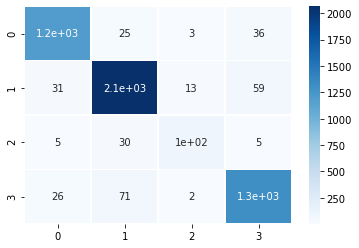

<Figure size 1152x1152 with 0 Axes>

In [ ]:
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
from sklearn.linear_model import LogisticRegression
    
#Display Confusion Matrix
X_test = np.vstack(df[df.t_t_v=='test']['features_lg'])
y_test = np.vstack(df[df.t_t_v=='test']['Category']).flatten()

# use validate and train for training (no validation here)
X_train = np.vstack(df[df.train | df.validate]['features_lg'])
y_train = np.vstack(df[df.train | df.validate]['Category']).flatten()


clf_log = LogisticRegression(C = 1, multi_class='ovr', max_iter=2000, solver='lbfgs')
clf_log.fit(X_train, y_train)
log_score = clf_log.score(X_test, y_test)
log_ypred = clf_log.predict(X_test)

log_confusion_matrix = confusion_matrix(y_test, log_ypred)
print(log_confusion_matrix)

disp = heatmap(log_confusion_matrix, annot=True, linewidths=0.5, cmap='Blues')
plt.savefig('log_Matrix.png')


plt.figure(figsize=(16,16))


# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

In [ ]:
D_ROOT/DBS['zappos'] 

Path('/home/ergonyc/Projects/DATABASE/ut-zap50k-images')

Confusion matrix, without normalization
[[1197   25    3   36]
 [  31 2066   13   59]
 [   5   30  100    5]
 [  26   71    2 1316]]
Normalized confusion matrix
[[0.94924663 0.01982554 0.00237906 0.02854877]
 [0.0142923  0.95251268 0.00599355 0.02720148]
 [0.03571429 0.21428571 0.71428571 0.03571429]
 [0.01837456 0.05017668 0.00141343 0.93003534]]


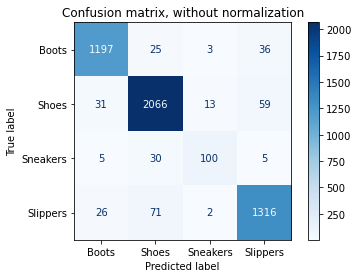

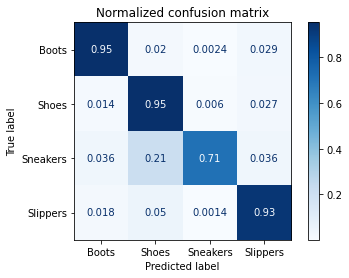

In [ ]:
class_names = df.Category.unique()

from sklearn.metrics import plot_confusion_matrix

for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf_log, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.savefig('log_Matrix2.png')

## transfer learning 

In [ ]:
#export
def transfer_mobilenet_v2(n_cat=4,freeze=True):
    model_conv = torchvision.models.mobilenet_v2(pretrained=True)
    # Parameters of newly constructed modules have requires_grad=True by default
    # just read this off: model_conv.classifier
    num_ftrs = model_conv.classifier._modules['1'].in_features
    model_conv.classifier._modules['1'] = nn.Linear(num_ftrs, n_cat)
    if freeze:
        for param in model_conv.parameters():
            param.requires_grad = False

    return model_conv

In [ ]:
#export
def prep_df_for_datablocks(df):
    df = df[["Category","path","train","test","validate","t_t_v"]].copy()
    # I could remove all the "test" rows... for now i'll choose an alternate strategy:
    # Drop all the "test" rows for now, and create an "is_valid" column...
    # should probably drop a ton of columns to jus tkeep the file paths...
    # just keep what we'll need below
    df.loc[:,'is_valid'] = df.test | df.validate
    return df


def get_zappos_cat_dataloaders(data=None,batch_size=32, size=IMG_SIZE, device=None):
    # put everythign in train, and don't do any augmentation since we are just going 
    # resize to 224
    # set up the helper functions to pass data into the
    if device is None:
        device = get_cuda()
    if data is None:
        filename = ZAPPOS_DF_SIMPLIFIED # "zappos-50k-simplified"
        data = pd.read_pickle(f"data/{filename}.pkl")
        
    images_path = D_ROOT/DBS['zappos']  
    def get_x(r): return images_path/r['path']
    def get_y(r): return r['Category']  # we aren't actually using the category here (see 02_model.ipynb)
    
    data = prep_df_for_datablocks(data)
    batch_tfms = Normalize.from_stats(*imagenet_stats)
    rand_tfms = aug_transforms(mult=1.0, 
                   do_flip=True, 
                   flip_vert=False, 
                   max_rotate=3.0, 
                   min_zoom=.95, 
                   max_zoom=1.0, 
                   max_lighting=0.1, 
                   max_warp=0.023, 
                   p_affine=0.66, 
                   p_lighting=0.2, 
                   xtra_tfms=None, 
                   size=None, 
                   mode='bilinear', 
                   pad_mode='border', 
                   align_corners=True, 
                   batch=False, 
                   min_scale=1.0)


                      
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   splitter=ColSplitter('is_valid'), 
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms=Resize(size, method='pad', pad_mode='border'),
                   batch_tfms=rand_tfms+[batch_tfms])  # border pads white...
    
    dls = dblock.dataloaders(data,bs=batch_size,drop_last=True,device=device)
    return dls



def transfer_mobilenet_v2(n_cat=4,freeze=True):
    model_conv = torchvision.models.mobilenet_v2(pretrained=True)
    # Parameters of newly constructed modules have requires_grad=True by default
    # just read this off: model_conv.classifier
    num_ftrs = model_conv.classifier._modules['1'].in_features
    model_conv.classifier._modules['1'] = nn.Linear(num_ftrs, n_cat)
    if freeze:
        for param in model_conv.parameters():
            param.requires_grad = False

    return model_conv

In [ ]:
#num_categories = 4

#transfer_mobilenet_v2(num_categories,freeze=True)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [ ]:
# export
# copied the split and cut from denseness ... need to check if the splits and cut make sense
def _mobilenet_v2_split(m:torch.nn.Module): 
    return L(m[0][0][:7],m[0][0][7:], m[1:]).map(params)

_mobilenet_v2_meta   = {'cut':-1, 'split':_mobilenet_v2_split, 'stats':imagenet_stats}

model_meta[torchvision.models.mobilenet_v2] = {**_mobilenet_v2_meta}



In [ ]:
filename = ZAPPOS_DF_SIMPLIFIED # "zappos-50k-simplified"
df = pd.read_pickle(f"data/{filename}.pkl")
df = prep_df_for_datablocks(df)

In [ ]:
#rnet_learn.save('rnet18_transfer-fep20_2x4')

rnet_learn = load_learner('models/rnet18_transfer-fep20_2x4.pth')
rnet_learn.show_results()

AttributeError: 'dict' object has no attribute 'dls'

In [ ]:
!ls models/

by_hand_finetune_10_200.pth  rnet18_transfer-fep20_1x2.pth
headlessmodel.pth	     rnet18_transfer-fep20_2x4.pth
learner_headless_mnetv2.pth  VAE_finetune_by_hand-fep10_ep200.pth
mnet_transfer-fep20_1x2.pth  VAE_finetune_by_hand-fep18_ep200.pth
mnet_transfer-fep20_2x4.pth  VAE_finetune_by_hand-fep18_ep400.pth


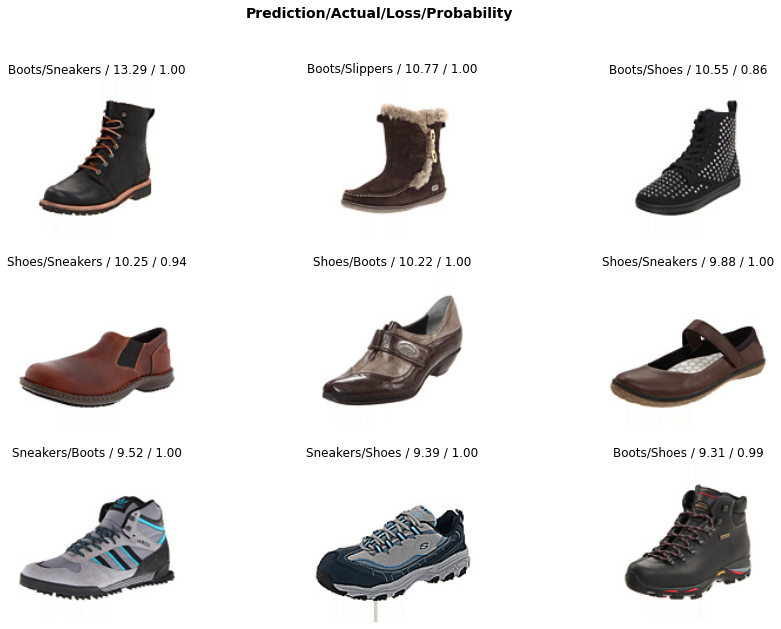

In [ ]:
interp = Interpretation.from_learner(rnet_learn)
interp.plot_top_losses(9, figsize=(15,10))

In [ ]:
rnet_learn.save('rnet18_transfer-fep20_1x2')

Path('models/rnet18_transfer-fep20_1x2.pth')

In [ ]:
mnet_learn.save('mnet_transfer-fep20_1x2')

Path('models/mnet_transfer-fep20_1x2.pth')

In [ ]:
mnet_learn.save('mnet_transfer-fep20_2x4')


Path('models/mnet_transfer-fep20_2x4.pth')

In [ ]:
# 
#mnet_learn.export(fname='mnet_transfer-feb20')

AttributeError: Can't pickle local object 'get_zappos_cat_dataloaders.<locals>.get_x'

## export

In [ ]:


from nbdev.export import notebook2script
notebook2script()



Converted 00_core.ipynb.
Converted 01scraped_data.ipynb.
Converted 01zappos_data.ipynb.
Converted 02a_model.ipynb.
Converted index.ipynb.
